In [2]:
import csv
import datetime
import itertools
import math
import os
import pickle
import subprocess
# Imports above are standard library
# Imports below are 3rd-party
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, recall_score, precision_score, silhouette_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, ComplementNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from statsmodels.api import qqplot
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
import statsmodels.api as sm
from xgboost import XGBClassifier, plot_importance

In [3]:
CATEGORY = "category"
IGNORE = "ignore"

## Kaggle API
You will need your own API key, which you can get by following instructions at https://github.com/Kaggle/kaggle-api/blob/main/docs/README.md

In [313]:
os.environ["KAGGLE_USERNAME"] = "jsf80238"
os.environ["KAGGLE_KEY"] = "4036359324650e1c13adfc7ba87ff90e"
import kaggle  # The import itself uses your KAGGLE_KEY, that's why the import is not at the top. Really.

dataset_name = "NCHS - Death Rates and Causes of Death"
command = "kaggle datasets list --csv --search".split()
#command.append("NCHS - Death Rates and Causes of Death")
result = subprocess.run(command + [dataset_name], capture_output=True)
data = result.stdout.decode(encoding="utf-8")
data[:100]

'ref,title,size,lastUpdated,downloadCount,voteCount,usabilityRating\r\ncdc/nchs-death-rates-and-causes-'

In [314]:
csvreader = csv.DictReader(data.splitlines())
for row in csvreader:
    if row["title"] == dataset_name:
        print(row)
        dataset_ref = row['ref']
        break
dataset_ref

{'ref': 'cdc/nchs-death-rates-and-causes-of-death', 'title': 'NCHS - Death Rates and Causes of Death', 'size': '3MB', 'lastUpdated': '2019-12-28 01:24:17', 'downloadCount': '1544', 'voteCount': '14', 'usabilityRating': '0.7647059'}


'cdc/nchs-death-rates-and-causes-of-death'

In [315]:
dataset_ref = "cdc/nchs-death-rates-and-causes-of-death"
file_name = "nchs-leading-causes-of-death-united-states.csv"
command = f"kaggle datasets download --unzip --force --file {file_name} {dataset_ref}".split()
result = subprocess.run(command, capture_output=True)
stdout = result.stdout.decode(encoding="utf-8")
stderr = result.stderr.decode(encoding="utf-8")
print(stdout)
print(stderr)
print(os.linesep.join(sorted(os.listdir("."))))



100%|██████████| 834k/834k [00:00<00:00, 2.99MB/s]

.ipynb_checkpoints
death_rate.ipynb
nchs-age-adjusted-death-rates-for-selected-major-causes-of-death.csv
nchs-leading-causes-of-death-united-states.csv
socrata_metadata_nchs-age-adjusted-death-rates-for-selected-major-causes-of-death.json
socrata_metadata_nchs-death-rates-and-life-expectancy-at-birth.json
socrata_metadata_nchs-leading-causes-of-death-united-states.json
socrata_metadata_nchs-potentially-excess-deaths-from-the-five-leading-causes-of-death.json
socrata_metadata_nchs-top-five-leading-causes-of-death-united-states-1990-1950-2000.json


## Kaggle workaround
If you were unable to download the cause-of-death file you can also grab it from my GitHub repo:

https://github.com/jsf80238/data_science/blob/main/data_files/nchs-leading-causes-of-death-united-states.csv

In [4]:
df = pd.read_csv(file_name)
df.info()

HTTPError: HTTP Error 404: Not Found

In [206]:
save_file = "nchs-leading-causes-of-death-united-states.df"
# with open(save_file, "wb") as writer:
#     pickle.dump(df, writer)

with open(save_file, "rb") as reader:
    df = pickle.load(reader)

df

,Year,113 Cause Name,Cause Name,State,Deaths,Age-adjusted Death Rate
0,2012,"Nephritis, nephrotic syndrome and nephrosis (N...",Kidney disease,Vermont,21,2.6
1,2017,"Nephritis, nephrotic syndrome and nephrosis (N...",Kidney disease,Vermont,29,3.3
2,2016,"Nephritis, nephrotic syndrome and nephrosis (N...",Kidney disease,Vermont,30,3.7
3,2013,"Nephritis, nephrotic syndrome and nephrosis (N...",Kidney disease,Vermont,30,3.8
4,2000,"Intentional self-harm (suicide) (*U03,X60-X84,...",Suicide,District of Columbia,23,3.8
...,...,...,...,...,...,...
10863,2001,All Causes,All causes,District of Columbia,5951,1049.9
10864,2002,All Causes,All causes,Mississippi,28853,1051.6
10865,2000,All Causes,All causes,Mississippi,28654,1051.9
10866,2000,All Causes,All causes,District of Columbia,6001,1061.2


In [207]:
YEAR = "year"
CAUSE = "cause_name"
STATE_NAME = "state_name"
DEATH_RATE = "death_rate"
df.drop(columns=["113 Cause Name", "Deaths"], inplace=True)
name_dict = {
    "Year": YEAR,
    "Cause Name": CAUSE,
    "State": STATE_NAME,
    "Age-adjusted Death Rate": DEATH_RATE,
}
df.rename(columns=name_dict, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10868 entries, 0 to 10867
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        10868 non-null  int64  
 1   cause_name  10868 non-null  object 
 2   state_name  10868 non-null  object 
 3   death_rate  10868 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 339.8+ KB


In [208]:
mask = (df[YEAR] >= 2010) & (df[STATE_NAME] != 'United States')
df = df[mask]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4488 entries, 0 to 10802
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        4488 non-null   int64  
 1   cause_name  4488 non-null   object 
 2   state_name  4488 non-null   object 
 3   death_rate  4488 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 175.3+ KB


In [209]:
df = df[[STATE_NAME, CAUSE, DEATH_RATE]].groupby([STATE_NAME, CAUSE]).mean().reset_index()
df

,state_name,cause_name,death_rate
0,Alabama,All causes,924.6125
1,Alabama,Alzheimer's disease,35.2625
2,Alabama,CLRD,55.5750
3,Alabama,Cancer,180.5125
4,Alabama,Diabetes,22.6875
...,...,...,...
556,Wyoming,Influenza and pneumonia,17.5750
557,Wyoming,Kidney disease,11.7625
558,Wyoming,Stroke,33.2625
559,Wyoming,Suicide,24.6750


## Census data
Nonemployer Statistics provides annual statistics on U.S. businesses with no paid employees or payroll at a detailed geography and industry level.

Statistics are available on businesses that have no paid employment or payroll, are subject to federal income taxes, and have receipts of $1,000 or more ($1 or more for the Construction sector). The data are available for approximately 450 NAICS industries at the national, state, county, metropolitan statistical area, and combined statistical area geography levels. The majority of NAICS industries are included.

https://www.census.gov/data/developers/data-sets/nonemp-api.2017.html#list-tab-1358655114

https://www.census.gov/data/developers/data-sets/nonemp-api.html
https://api.census.gov/data/2017/nonemp/variables.html

https://www2.census.gov/programs-surveys/nonemployer-statistics/technical-documentation/record-layouts/state-record-layout/state_record_layout_2017.txt

### Definitions
* LFO = Legal form of organization
* NAICS2017_LABEL = type of business
* NAME = geo areas, including states
* NESTAB = Number of nonemployer establishments
* NRCPTOT = Nonemployer sales, value of shipments, or revenue ($1,000)
* RCPSZES_LABEL = Separates establishments into groups by sales/receipts, including "All establishments"

In [210]:
CENSUS_API_KEY = "35b2edd7f868b6d6f79e5988091d0f8df6ffbd2a"

In [211]:
STATE_KEY = "state_key"
POPULATION = "population"
KEY = "key"
CENSUS_DEMOGRAPHICS_URL = "https://api.census.gov/data/2019/pep/charagegroups"
param_dict = {'get': 'NAME,POP', 'for': 'state:*', KEY: CENSUS_API_KEY}

In [212]:
response = requests.get(CENSUS_DEMOGRAPHICS_URL, params=param_dict)

In [213]:
result_list = response.json()  # The return from the API call is a list of lists, with first item being the column names
column_name_list = result_list.pop(0)
states_df = pd.DataFrame(result_list, columns=column_name_list)
states_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   NAME    52 non-null     object
 1   POP     52 non-null     object
 2   state   52 non-null     object
dtypes: object(3)
memory usage: 1.3+ KB


In [214]:
name_dict = {
    "NAME": STATE_NAME,
    "POP": POPULATION,
    "state": STATE_KEY,
}
states_df.rename(columns=name_dict, inplace=True)
states_df[POPULATION] = states_df[POPULATION].astype(int)
states_df[STATE_KEY] = states_df[STATE_KEY].astype(int)
states_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   state_name  52 non-null     object
 1   population  52 non-null     int64 
 2   state_key   52 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.3+ KB


In [215]:
states_df[POPULATION].sum()  # Expected value ~330 million

331433217

In [216]:
df = df.merge(states_df, on=STATE_NAME, how="inner")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   state_name  561 non-null    object 
 1   cause_name  561 non-null    object 
 2   death_rate  561 non-null    float64
 3   population  561 non-null    int64  
 4   state_key   561 non-null    int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 22.0+ KB


In [217]:
NESTAB = "NESTAB"
NRCPTOT = "NRCPTOT"
LFO = "LFO"
NAICS2017 = "NAICS2017"

CENSUS_NONEMPLOYER_URL = "https://api.census.gov/data/2017/nonemp"
param_dict = {'get': ','.join((LFO, NESTAB, NRCPTOT)), 'for': 'state:*', NAICS2017: '*', KEY: CENSUS_API_KEY}

In [329]:
# This cell may take a minute or two
response = requests.get(CENSUS_NONEMPLOYER_URL, params=param_dict)

In [330]:
result_list = response.json()  # The return from the API call is a list of lists, with first item being the column names
column_name_list = result_list.pop(0)
business_df = pd.DataFrame(result_list, columns=column_name_list)
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109381 entries, 0 to 109380
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   LFO        109381 non-null  object
 1   NESTAB     109381 non-null  object
 2   NRCPTOT    109381 non-null  object
 3   NAICS2017  109381 non-null  object
 4   state      109381 non-null  object
dtypes: object(5)
memory usage: 4.2+ MB


In [218]:
save_file = "census.df"
# with open(save_file, "wb") as writer:
#     pickle.dump(business_df, writer)

with open(save_file, "rb") as reader:
    business_df = pickle.load(reader)

business_df

,LFO,NESTAB,NRCPTOT,NAICS2017,state
0,001,219596,8889009,00,28
1,9101,1750,206357,00,28
2,9111,6527,848178,00,28
3,920,198380,6220549,00,28
4,930,12939,1613925,00,28
...,...,...,...,...,...
109376,001,4930,58618,813,18
109377,9101,49,1913,813,18
109378,9111,9,360,813,18
109379,920,4864,56215,813,18


In [219]:
LEGAL_FORM = "legal_form"
BUSINESS_TYPE = "business_type"
ESTABLISHMENT_COUNT = "establishment_count"
REVENUE_IN_THOUSANDS = "revenue_in_thousands"
REVENUE_CATEGORY = "revenue_category"
name_dict = {
    "state": STATE_KEY,
    "NAICS2017": BUSINESS_TYPE,
    "LFO": LEGAL_FORM,
    "NESTAB": ESTABLISHMENT_COUNT,
    "NRCPTOT": REVENUE_IN_THOUSANDS,
}
business_df.rename(columns=name_dict, inplace=True)
business_df = business_df.reindex([STATE_KEY, LEGAL_FORM, BUSINESS_TYPE, ESTABLISHMENT_COUNT, REVENUE_IN_THOUSANDS], axis=1)
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109381 entries, 0 to 109380
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   state_key             109381 non-null  object
 1   legal_form            109381 non-null  object
 2   business_type         109381 non-null  object
 3   establishment_count   109381 non-null  object
 4   revenue_in_thousands  109381 non-null  object
dtypes: object(5)
memory usage: 4.2+ MB


In [220]:
for column_name in ESTABLISHMENT_COUNT, REVENUE_IN_THOUSANDS, STATE_KEY:
    business_df[column_name] = business_df[column_name].astype(int)
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109381 entries, 0 to 109380
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   state_key             109381 non-null  int64 
 1   legal_form            109381 non-null  object
 2   business_type         109381 non-null  object
 3   establishment_count   109381 non-null  int64 
 4   revenue_in_thousands  109381 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 4.2+ MB


In [221]:
business_df

,state_key,legal_form,business_type,establishment_count,revenue_in_thousands
0,28,001,00,219596,8889009
1,28,9101,00,1750,206357
2,28,9111,00,6527,848178
3,28,920,00,198380,6220549
4,28,930,00,12939,1613925
...,...,...,...,...,...
109376,18,001,813,4930,58618
109377,18,9101,813,49,1913
109378,18,9111,813,9,360
109379,18,920,813,4864,56215


## Check for duplicate rows

In [222]:
mask = business_df[[STATE_KEY, BUSINESS_TYPE, LEGAL_FORM]].duplicated()
business_df[mask]

,state_key,legal_form,business_type,establishment_count,revenue_in_thousands


## Check for holes
Verify this data does not have holes, meaning verify every combination of legal_form/business_type exists for every state.

If something is missing, add it with np.nan for the establishment_count and revenue.

In [223]:
state_list = business_df[STATE_KEY].unique()
legal_form_list = business_df[LEGAL_FORM].unique()
business_type_list = business_df[BUSINESS_TYPE].unique()
wanted_combinations_set = set(itertools.product(state_list, legal_form_list, business_type_list))
print(f"{len(wanted_combinations_set):,} possible combinations, for example:")
for i, item in enumerate(wanted_combinations_set):
    print(item)
    if i > 10:
        break


119,850 possible combinations, for example:
(39, '930', '519')
(44, '930', '45392')
(34, '9111', '5615')
(30, '930', '3256')
(46, '920', '4483')
(10, '9111', '7121')
(12, '9101', '533')
(45, '001', '4851')
(21, '9101', '45111')
(36, '920', '4542')
(32, '920', '53')
(25, '920', '56143')


In [224]:
existing_combinations_set = set()
for item in business_df[[STATE_KEY, LEGAL_FORM, BUSINESS_TYPE]].to_records(index=False):
    existing_combinations_set.add(tuple(item))
print(f"{len(existing_combinations_set):,} existing combinations, for example:")
for i, item in enumerate(existing_combinations_set):
    print(item)
    if i > 10:
        break

109,381 existing combinations, for example:
(39, '930', '519')
(44, '930', '45392')
(34, '9111', '5615')
(30, '930', '3256')
(46, '920', '4483')
(10, '9111', '7121')
(12, '9101', '533')
(45, '001', '4851')
(21, '9101', '45111')
(36, '920', '4542')
(32, '920', '53')
(25, '920', '56143')


In [225]:
missing_combinations_set = wanted_combinations_set - existing_combinations_set
print(f"{len(missing_combinations_set):,} missing combinations, for example:")
for i, item in enumerate(missing_combinations_set):
    print(item)
    if i > 10:
        break

10,469 missing combinations, for example:
(46, '930', '4852')
(46, '9101', '81293')
(15, '930', '54194')
(20, '930', '316')
(44, '9101', '3116')
(33, '930', '532283')
(38, '930', '44521')
(49, '9101', '3273')
(21, '9101', '322')
(32, '9111', '316')
(35, '9101', '42493')
(44, '9101', '31111')


In [226]:
missing_data = [list(combo) + [np.nan, np.nan] for combo in missing_combinations_set]
missing_data[:10]

[[46, '930', '4852', nan, nan],
 [46, '9101', '81293', nan, nan],
 [15, '930', '54194', nan, nan],
 [20, '930', '316', nan, nan],
 [44, '9101', '3116', nan, nan],
 [33, '930', '532283', nan, nan],
 [38, '930', '44521', nan, nan],
 [49, '9101', '3273', nan, nan],
 [21, '9101', '322', nan, nan],
 [32, '9111', '316', nan, nan]]

In [227]:
missing_df = pd.DataFrame.from_records(missing_data)
missing_df.columns = [STATE_KEY, LEGAL_FORM, BUSINESS_TYPE, ESTABLISHMENT_COUNT, REVENUE_IN_THOUSANDS]
missing_df

,state_key,legal_form,business_type,establishment_count,revenue_in_thousands
0,46,930,4852,NaN,NaN
1,46,9101,81293,NaN,NaN
2,15,930,54194,NaN,NaN
3,20,930,316,NaN,NaN
4,44,9101,3116,NaN,NaN
...,...,...,...,...,...
10464,9,930,314,NaN,NaN
10465,15,9111,31611,NaN,NaN
10466,50,930,451212,NaN,NaN
10467,33,9101,6241,NaN,NaN


In [228]:
business_df = pd.concat([business_df, missing_df], ignore_index=True)
business_df

,state_key,legal_form,business_type,establishment_count,revenue_in_thousands
0,28,001,00,219596.0,8889009.0
1,28,9101,00,1750.0,206357.0
2,28,9111,00,6527.0,848178.0
3,28,920,00,198380.0,6220549.0
4,28,930,00,12939.0,1613925.0
...,...,...,...,...,...
119845,9,930,314,NaN,NaN
119846,15,9111,31611,NaN,NaN
119847,50,930,451212,NaN,NaN
119848,33,9101,6241,NaN,NaN


## Merge cause of death data with business data

In [229]:
df = df.merge(business_df, on=STATE_KEY, how="inner")
df

,state_name,cause_name,death_rate,population,state_key,legal_form,business_type,establishment_count,revenue_in_thousands
0,Alabama,All causes,924.6125,4903185,1,001,00,329993.0,14091009.0
1,Alabama,All causes,924.6125,4903185,1,9101,00,2170.0,296379.0
2,Alabama,All causes,924.6125,4903185,1,9111,00,10571.0,1445496.0
3,Alabama,All causes,924.6125,4903185,1,920,00,294694.0,9447160.0
4,Alabama,All causes,924.6125,4903185,1,930,00,22558.0,2901974.0
...,...,...,...,...,...,...,...,...,...
1318345,Wyoming,Unintentional injuries,58.7000,578759,56,9101,42491,NaN,NaN
1318346,Wyoming,Unintentional injuries,58.7000,578759,56,9111,44412,NaN,NaN
1318347,Wyoming,Unintentional injuries,58.7000,578759,56,930,7132,NaN,NaN
1318348,Wyoming,Unintentional injuries,58.7000,578759,56,9101,8122,NaN,NaN


## Adjust for population
We would expect the number of establishments and revenue to be higher in more populous states.

Adjust.

In [230]:
ESTABLISHMENTS_PP = "establishments_pp"
REVENUE_PP = "revenue_pp"
df[ESTABLISHMENTS_PP] = df[ESTABLISHMENT_COUNT] / df[POPULATION]
df[REVENUE_PP] = df[REVENUE_IN_THOUSANDS] / df[POPULATION]
df

,state_name,cause_name,death_rate,population,state_key,legal_form,business_type,establishment_count,revenue_in_thousands,establishments_pp,revenue_pp
0,Alabama,All causes,924.6125,4903185,1,001,00,329993.0,14091009.0,0.067302,2.873848
1,Alabama,All causes,924.6125,4903185,1,9101,00,2170.0,296379.0,0.000443,0.060446
2,Alabama,All causes,924.6125,4903185,1,9111,00,10571.0,1445496.0,0.002156,0.294808
3,Alabama,All causes,924.6125,4903185,1,920,00,294694.0,9447160.0,0.060103,1.926739
4,Alabama,All causes,924.6125,4903185,1,930,00,22558.0,2901974.0,0.004601,0.591855
...,...,...,...,...,...,...,...,...,...,...,...
1318345,Wyoming,Unintentional injuries,58.7000,578759,56,9101,42491,NaN,NaN,NaN,NaN
1318346,Wyoming,Unintentional injuries,58.7000,578759,56,9111,44412,NaN,NaN,NaN,NaN
1318347,Wyoming,Unintentional injuries,58.7000,578759,56,930,7132,NaN,NaN,NaN,NaN
1318348,Wyoming,Unintentional injuries,58.7000,578759,56,9101,8122,NaN,NaN,NaN,NaN


## Categorization of data
Let's make population, establishment_pp and revenue_pp categories

Distribution plots will help us decide how to make the cuts.

7 for population.
64 for establishments_pp.
84 for revenue_pp.


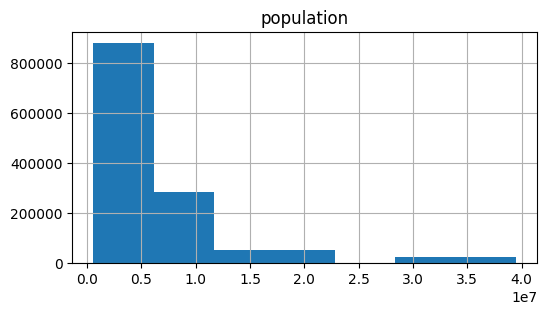

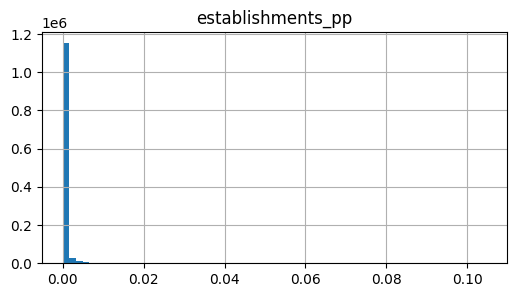

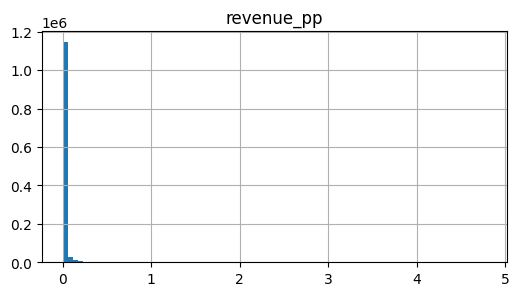

In [231]:
for column_name in POPULATION, ESTABLISHMENTS_PP, REVENUE_PP:
    number_of_observations = df[column_name].nunique()
    # Rice's rule
    suggested_bin_count = int(math.cbrt(number_of_observations)*2)
    print(f"{suggested_bin_count} for {column_name}.")
    df.hist(column=column_name, bins=suggested_bin_count, figsize=(6, 3))

## Binning conclusion
Population: 7 cuts based on absolute population

Establishments and revenue: 7 cuts with equal numbers of observations in each bin

In [232]:
XXSMALL = "xx-small"
XSMALL = "x-small"
SMALL = "small"
MEDIUM = "medium"
LARGE = "large"
XLARGE = "x-large"
XXLARGE = "xx-large"

POPULATION_BIN = "population_bin"
ESTABLISHMENTS_BIN = "establishments_bin"
REVENUE_BIN = "revenue_bin"

df[POPULATION_BIN] = pd.cut(df[POPULATION], 7, labels=[XXSMALL, XSMALL, SMALL, MEDIUM, LARGE, XLARGE, XXLARGE])
df[ESTABLISHMENTS_BIN] = pd.qcut(df[ESTABLISHMENTS_PP], 7, labels=[XXSMALL, XSMALL, SMALL, MEDIUM, LARGE, XLARGE, XXLARGE])
df[REVENUE_BIN] = pd.qcut(df[REVENUE_PP], 7, labels=[XXSMALL, XSMALL, SMALL, MEDIUM, LARGE, XLARGE, XXLARGE])

for column_name in POPULATION_BIN, ESTABLISHMENTS_BIN, REVENUE_BIN:
    print(df[column_name].value_counts())

df

population_bin
xx-small    878900
x-small     284350
small        51700
medium       51700
x-large      25850
xx-large     25850
large            0
Name: count, dtype: int64
establishments_bin
xx-small    172183
x-small     171886
x-large     171886
xx-large    171875
medium      171853
large       171853
small       171655
Name: count, dtype: int64
revenue_bin
xx-small    171886
x-small     171886
small       171886
medium      171886
large       171886
x-large     171886
xx-large    171875
Name: count, dtype: int64


,state_name,cause_name,death_rate,population,state_key,legal_form,business_type,establishment_count,revenue_in_thousands,establishments_pp,revenue_pp,population_bin,establishments_bin,revenue_bin
0,Alabama,All causes,924.6125,4903185,1,001,00,329993.0,14091009.0,0.067302,2.873848,xx-small,xx-large,xx-large
1,Alabama,All causes,924.6125,4903185,1,9101,00,2170.0,296379.0,0.000443,0.060446,xx-small,xx-large,xx-large
2,Alabama,All causes,924.6125,4903185,1,9111,00,10571.0,1445496.0,0.002156,0.294808,xx-small,xx-large,xx-large
3,Alabama,All causes,924.6125,4903185,1,920,00,294694.0,9447160.0,0.060103,1.926739,xx-small,xx-large,xx-large
4,Alabama,All causes,924.6125,4903185,1,930,00,22558.0,2901974.0,0.004601,0.591855,xx-small,xx-large,xx-large
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318345,Wyoming,Unintentional injuries,58.7000,578759,56,9101,42491,NaN,NaN,NaN,NaN,xx-small,NaN,NaN
1318346,Wyoming,Unintentional injuries,58.7000,578759,56,9111,44412,NaN,NaN,NaN,NaN,xx-small,NaN,NaN
1318347,Wyoming,Unintentional injuries,58.7000,578759,56,930,7132,NaN,NaN,NaN,NaN,xx-small,NaN,NaN
1318348,Wyoming,Unintentional injuries,58.7000,578759,56,9101,8122,NaN,NaN,NaN,NaN,xx-small,NaN,NaN


## Set establishments_bin and revenue_bin to XXSMALL where currently NaN
These did not exist at all in the original data, meaning their true value is zero, so XXSMALL is a good category.

In [233]:
df[ESTABLISHMENTS_BIN] = df[ESTABLISHMENTS_BIN].fillna(XXSMALL)
df[REVENUE_BIN] = df[REVENUE_BIN].fillna(XXSMALL)
df

,state_name,cause_name,death_rate,population,state_key,legal_form,business_type,establishment_count,revenue_in_thousands,establishments_pp,revenue_pp,population_bin,establishments_bin,revenue_bin
0,Alabama,All causes,924.6125,4903185,1,001,00,329993.0,14091009.0,0.067302,2.873848,xx-small,xx-large,xx-large
1,Alabama,All causes,924.6125,4903185,1,9101,00,2170.0,296379.0,0.000443,0.060446,xx-small,xx-large,xx-large
2,Alabama,All causes,924.6125,4903185,1,9111,00,10571.0,1445496.0,0.002156,0.294808,xx-small,xx-large,xx-large
3,Alabama,All causes,924.6125,4903185,1,920,00,294694.0,9447160.0,0.060103,1.926739,xx-small,xx-large,xx-large
4,Alabama,All causes,924.6125,4903185,1,930,00,22558.0,2901974.0,0.004601,0.591855,xx-small,xx-large,xx-large
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318345,Wyoming,Unintentional injuries,58.7000,578759,56,9101,42491,NaN,NaN,NaN,NaN,xx-small,xx-small,xx-small
1318346,Wyoming,Unintentional injuries,58.7000,578759,56,9111,44412,NaN,NaN,NaN,NaN,xx-small,xx-small,xx-small
1318347,Wyoming,Unintentional injuries,58.7000,578759,56,930,7132,NaN,NaN,NaN,NaN,xx-small,xx-small,xx-small
1318348,Wyoming,Unintentional injuries,58.7000,578759,56,9101,8122,NaN,NaN,NaN,NaN,xx-small,xx-small,xx-small


## Cleanup
We have columns we don't need.

In [234]:
df.drop(columns=[POPULATION, STATE_KEY, ESTABLISHMENT_COUNT, REVENUE_IN_THOUSANDS, ESTABLISHMENTS_PP, REVENUE_PP], inplace=True)
df

,state_name,cause_name,death_rate,legal_form,business_type,population_bin,establishments_bin,revenue_bin
0,Alabama,All causes,924.6125,001,00,xx-small,xx-large,xx-large
1,Alabama,All causes,924.6125,9101,00,xx-small,xx-large,xx-large
2,Alabama,All causes,924.6125,9111,00,xx-small,xx-large,xx-large
3,Alabama,All causes,924.6125,920,00,xx-small,xx-large,xx-large
4,Alabama,All causes,924.6125,930,00,xx-small,xx-large,xx-large
...,...,...,...,...,...,...,...,...
1318345,Wyoming,Unintentional injuries,58.7000,9101,42491,xx-small,xx-small,xx-small
1318346,Wyoming,Unintentional injuries,58.7000,9111,44412,xx-small,xx-small,xx-small
1318347,Wyoming,Unintentional injuries,58.7000,930,7132,xx-small,xx-small,xx-small
1318348,Wyoming,Unintentional injuries,58.7000,9101,8122,xx-small,xx-small,xx-small


## Categorize death rates
We need to do this for each cause of death, because they are not really comparable to each other.

7 for All causes.
7 for Alzheimer's disease.
7 for CLRD.
7 for Cancer.
7 for Diabetes.
7 for Heart disease.
7 for Influenza and pneumonia.
7 for Kidney disease.
7 for Stroke.
7 for Suicide.
7 for Unintentional injuries.


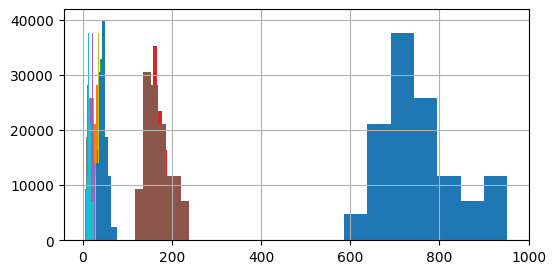

In [235]:
for cause_name in df[CAUSE].unique():
    mask = (df[CAUSE] == cause_name)
    number_of_observations = df[mask][DEATH_RATE].nunique()
    # Rice's rule
    suggested_bin_count = int(math.cbrt(number_of_observations)*2)
    print(f"{suggested_bin_count} for {cause_name}.")
    df[mask][DEATH_RATE].hist(bins=suggested_bin_count, figsize=(6, 3))

In [236]:
DEATH_RATE_BIN = "death_rate_bin"
try:
    df.drop(columns=[DEATH_RATE_BIN], inplace=True)
except KeyError:
    pass

all_labels_df = pd.DataFrame()

for cause_name in df[CAUSE].unique():
    print(cause_name)
    mask = (df[CAUSE] == cause_name)
    cause_labels = pd.qcut(df[mask][DEATH_RATE], 7, labels=[XXSMALL, XSMALL, SMALL, MEDIUM, LARGE, XLARGE, XXLARGE])
    if all_labels_df.size:
        all_labels_df = pd.concat([all_labels_df, cause_labels])
    else:
        all_labels_df = cause_labels

all_labels_df.shape

All causes
Alzheimer's disease
CLRD
Cancer
Diabetes
Heart disease
Influenza and pneumonia
Kidney disease
Stroke
Suicide
Unintentional injuries


(1318350,)

In [237]:
df = df.merge(all_labels_df, left_index=True, right_index=True, suffixes=(None, "_bin"))
df[DEATH_RATE_BIN].value_counts()
df

,state_name,cause_name,death_rate,legal_form,business_type,population_bin,establishments_bin,revenue_bin,death_rate_bin
0,Alabama,All causes,924.6125,001,00,xx-small,xx-large,xx-large,xx-large
1,Alabama,All causes,924.6125,9101,00,xx-small,xx-large,xx-large,xx-large
2,Alabama,All causes,924.6125,9111,00,xx-small,xx-large,xx-large,xx-large
3,Alabama,All causes,924.6125,920,00,xx-small,xx-large,xx-large,xx-large
4,Alabama,All causes,924.6125,930,00,xx-small,xx-large,xx-large,xx-large
...,...,...,...,...,...,...,...,...,...
1318345,Wyoming,Unintentional injuries,58.7000,9101,42491,xx-small,xx-small,xx-small,xx-large
1318346,Wyoming,Unintentional injuries,58.7000,9111,44412,xx-small,xx-small,xx-small,xx-large
1318347,Wyoming,Unintentional injuries,58.7000,930,7132,xx-small,xx-small,xx-small,xx-large
1318348,Wyoming,Unintentional injuries,58.7000,9101,8122,xx-small,xx-small,xx-small,xx-large


## Create different frames for each cause of death
The factors leading to a higher death rate might be different based on cause of death.

In [277]:
frames_by_cause_dict = dict()
for cause_name in df[CAUSE].unique():
    mask = (df[CAUSE] == cause_name)
    new_df = df[mask].copy()
    new_df.drop(columns=[CAUSE, STATE_NAME, POPULATION, ESTABLISHMENTS_PP, REVENUE_PP], inplace=True)
    new_df[LEGAL_FORM] = new_df[LEGAL_FORM].astype(CATEGORY)
    new_df[BUSINESS_TYPE] = new_df[BUSINESS_TYPE].astype(CATEGORY)
    new_df = new_df.reindex([LEGAL_FORM, BUSINESS_TYPE, POPULATION_BIN, ESTABLISHMENTS_BIN, REVENUE_BIN, DEATH_RATE], axis=1)
    frames_by_cause_dict[cause_name] = new_df
frames_by_cause_dict["Heart disease"].info()

<class 'pandas.core.frame.DataFrame'>
Index: 119850 entries, 11750 to 1306599
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   legal_form          119850 non-null  category
 1   business_type       119850 non-null  category
 2   population_bin      119850 non-null  category
 3   establishments_bin  109381 non-null  category
 4   revenue_bin         109381 non-null  category
 5   death_rate          119850 non-null  float64 
dtypes: category(5), float64(1)
memory usage: 2.5 MB


## Census codes
I've gone to the trouble of downloading these.
* North American Industry Classification System (aka NAIC)
  * [Original](https://www.census.gov/naics/?58967?yearbck=2017)
  * [Used version](https://github.com/jsf80238/data_science/blob/main/data_files/naics_codes.csv)
* Legal Form of Organization
  * [Original](https://www2.census.gov/programs-surveys/abs/technical-documentation/api/NESD-Technical-Employer-and-Nonemployer-API-5242022Final.pdf)
  * [Used version](https://github.com/jsf80238/data_science/blob/main/data_files/legal_form_codes.csv)